# Misinformation and Suspensions

## Setting the scene

In [184]:
import pandas as pd
import numpy as np
import scipy.stats as stats

* For this analysis, we will use data of tweeter accounts to try and predict suspension

* The dataset represents user activity regarding the 2020 elections of the United States of America

In [185]:
accounts = pd.read_csv("mosleh_et_al_data.csv")
accounts.head()

,politics_sites2,politics_sites1,politics_followed,lowqual_pr2019_crowd,lowqual_pr2019_fc,lowqual_afm,lowqual_mbfc,lowqual_lasser2019,suspended,politics_hashtag,...,valence_neg,valence_neu,valence_pos,politics_sites2_ideo_std,hashtag_ideo_std,barbera_std,politics_sites1_std,repeated_tweet_count,freq_pr_1h,bad_domain_count
0,-0.231902,-1.168745,-0.080295,0.598883,0.279221,0.185315,0.292807,0.350000,0,0,...,0.109935,0.813230,0.076835,0.274317,0.0,0.909460,69,86.0,30,7
1,0.405261,1.060905,2.296375,0.774873,0.848639,0.614156,0.513147,0.975087,0,1,...,0.115985,0.793715,0.090250,0.351800,0.0,0.157056,623,133.0,26,20
2,-0.171067,-0.500076,-2.312730,0.548727,0.242347,0.130950,0.242445,0.300000,0,0,...,0.085765,0.817340,0.096915,0.279591,0.0,0.445349,32,3.0,3,6
3,-0.085814,-0.748035,-1.507481,0.611501,0.360119,0.180055,0.277793,0.316038,0,0,...,0.108680,0.781135,0.110190,0.290277,0.0,0.256665,55,104.0,29,22
4,0.595367,1.347730,2.010573,0.700217,0.698661,0.430655,0.554609,0.763889,0,1,...,0.065145,0.860550,0.074320,0.300823,0.0,0.431149,37,36.0,8,8


## Suspensions Analysis

* We will start with some simple descriptions of our data set

In [186]:
hashtags_politics = accounts[["politics_hashtag", "suspended"]]
hashtags_politics.head()

,politics_hashtag,suspended
0,0,0
1,1,0
2,0,0
3,0,0
4,1,0


* Accounts that shared `#Trump2020` will have 1 on `politics_hashtag`, while accounts that shared `#VoteBidenHarris2020` will have a 0

In [187]:
cross_tab = pd.crosstab(hashtags_politics["politics_hashtag"], hashtags_politics["suspended"], margins = True)
cross_tab

suspended,0,1,All
politics_hashtag,,,
0,4295,200,4495
1,3623,882,4505
All,7918,1082,9000


* The above table is a good lookup to retrieve the suspensions/ non suspensions of each side

* Lets compute the percentages (or probabilities) of the suspensions with respect to the political views of the accounts

* First for Trump:

In [188]:
trumps_suspension_rate = cross_tab[1][1] / cross_tab["All"][1]
trumps_suspension_rate

np.float64(0.1957824639289678)

* And for Biden:

In [189]:
bidens_suspension_rate = cross_tab[1][0] / cross_tab["All"][0]
bidens_suspension_rate

np.float64(0.04449388209121246)

* It appears that almost 20% of Trumps' supporters were suspended, while Bidens' supporters have a 4,5% probability of suspension

* Lets combine the above percentages so we can compare them more easily

In [190]:
trumps_suspension_rate / bidens_suspension_rate

np.float64(4.400210876803551)

* Just like Mosleh et al figured out, accounts that had shared `#Trump2020` during
the election were 4.4 times more likely to have been subsequently suspended than those that shared `#VoteBidenHarris2020`

## Hypothesis

* We want to know if there exists a significant relationship between ones political affiliation and the chance he gets suspended

* That means we want to know if `politics_hashtag` has an effect on the probability of suspension

* More simply, we have to calculate the probability that any observed difference between the groups, arose by chance

* To do that, we will perform a $X^2$ test, with the null hypothesis ($H_0$) that political orientation and suspension, are independent of each other

* Lets start by removing the margins from our original cross tabulation, to retain only the frequencies

In [191]:
cross_tab.drop(index="All", columns="All", inplace=True)
cross_tab

suspended,0,1
politics_hashtag,,
0,4295,200
1,3623,882


* And run the test

In [192]:
chisquare_model = stats.chisquare(f_obs=cross_tab)
print(f"Xsquares = {chisquare_model.statistic}\nPvalues = {chisquare_model.pvalue}")

Xsquares = [ 57.03258399 429.87430684]
Pvalues = [4.28650646e-14 1.73079311e-95]


* The first values are the results for the "Not suspended" state (0), while the second are for the "suspended" state (1)

* By summing our results for both the states, we get the complete picture

In [193]:
print(f"Xsquare = {chisquare_model.statistic.sum()}")
print(f"Pvalue = {chisquare_model.pvalue.sum()}")

Xsquare = 486.9068908250417
Pvalue = 4.286506455369322e-14


* The difference between the observed and the theoretical frequencies distribution is the $X^2$ statistic (which denotes a sum of squared deviations)

* To interpret the results, we can use a standard significance threshold, $a$, of 5%

* Since $Pvalue$ <<< $a$, we can reject our initial hypothesis (with a confidence of 95%)

* We do that, because the test indicates that there is a difference in the two probabilities (percentages), and that denotes that the state of an account is indeed influenced by the `politics_hashtag` factor

* So it appears that the relation between ones political beliefs and the chance he gets suspended, is significant

* That means that if someone told us that an account posted #Trump2020 or #VoteBidenHarris2020, we can predict, with some confidence, the suspension state of said account

## Distributions

* At this point, we would like to get an idea of which group (0 or 1) spreads the most misinformation

* To do that, we will need the opinions on what is considered "misinformation" from both experts (called fact checkers) and the general crowd

* Lets start with the fact checkers and create a distribution plot

In [194]:
hashtag_lowquality = accounts[["politics_hashtag", "lowqual_pr2019_fc"]]
hashtag_lowquality.head()

,politics_hashtag,lowqual_pr2019_fc
0,0,0.279221
1,1,0.848639
2,0,0.242347
3,0,0.360119
4,1,0.698661


* The fact checkers have rated each account based on the low-quality news shares it has made

* Lets have a look at our data

In [195]:
hashtag_lowquality.describe()

,politics_hashtag,lowqual_pr2019_fc
count,9000.000000,8945.000000
mean,0.500556,0.466415
std,0.500027,0.239274
min,0.000000,0.071429
25%,0.000000,0.235390
50%,1.000000,0.457143
75%,1.000000,0.702773
max,1.000000,0.989881


* We would like to normalize `lowqual_pr2019_fc` using z-scores, so the mean of the data is 0 and the standard deviation, 1

* We will use a `StandardScaler` for that, since it can take care of that for us

In [196]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hashtag_lowquality.loc[:, ["lowqual_pr2019_fc_SCALED"]] = scaler.fit_transform(hashtag_lowquality[["lowqual_pr2019_fc"]])

* We can see we achieved our goal

In [197]:
hashtag_lowquality.describe()

,politics_hashtag,lowqual_pr2019_fc,lowqual_pr2019_fc_SCALED
count,9000.000000,8945.000000,8.945000e+03
mean,0.500556,0.466415,-2.351265e-16
std,0.500027,0.239274,1.000056e+00
min,0.000000,0.071429,-1.650861e+00
25%,0.000000,0.235390,-9.655804e-01
50%,1.000000,0.457143,-3.875435e-02
75%,1.000000,0.702773,9.878643e-01
max,1.000000,0.989881,2.187845e+00


* Time to plot

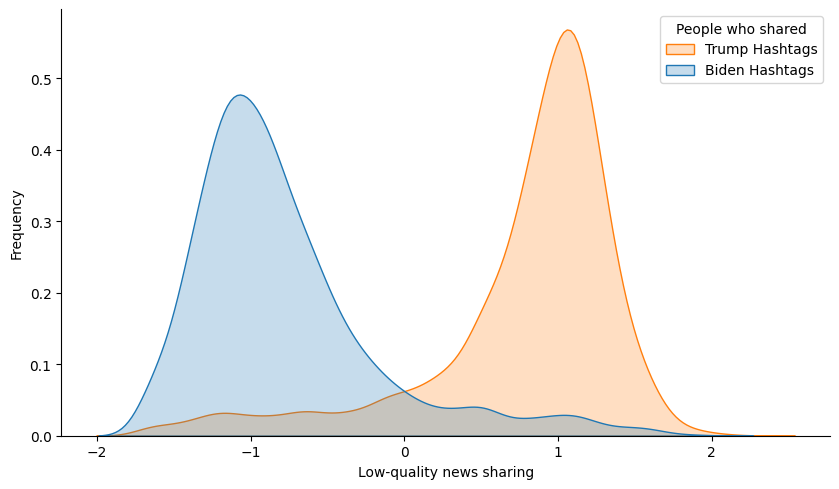

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

hashtag_labels = ["Trump Hashtags", "Biden Hashtags"]

distplot = sns.displot(
    hashtag_lowquality,
    x="lowqual_pr2019_fc_SCALED",
    kind="kde",
    fill=True,
    hue="politics_hashtag",
    aspect=1.7,
    legend=False
)

plt.xlabel("Low-quality news sharing")
plt.ylabel("Frequency")
plt.grid(()) # remove gird
_ = plt.legend(title = "People who shared", labels = hashtag_labels)

* Lets replicate our results, this time with the opinion of the crowd (instead of fact checkers)

In [199]:
hashtag_lowquality = pd.concat([hashtag_lowquality, accounts[["lowqual_pr2019_crowd"]]], axis = 1)
hashtag_lowquality.head()

,politics_hashtag,lowqual_pr2019_fc,lowqual_pr2019_fc_SCALED,lowqual_pr2019_crowd
0,0,0.279221,-0.782386,0.598883
1,1,0.848639,1.597521,0.774873
2,0,0.242347,-0.936502,0.548727
3,0,0.360119,-0.444269,0.611501
4,1,0.698661,0.970679,0.700217


* Again, we follow the same process

In [200]:
hashtag_lowquality.describe()

,politics_hashtag,lowqual_pr2019_fc,lowqual_pr2019_fc_SCALED,lowqual_pr2019_crowd
count,9000.000000,8945.000000,8.945000e+03,8945.000000
mean,0.500556,0.466415,-2.351265e-16,0.637918
std,0.500027,0.239274,1.000056e+00,0.072139
min,0.000000,0.071429,-1.650861e+00,0.524729
25%,0.000000,0.235390,-9.655804e-01,0.567706
50%,1.000000,0.457143,-3.875435e-02,0.633167
75%,1.000000,0.702773,9.878643e-01,0.704621
max,1.000000,0.989881,2.187845e+00,0.823364


In [201]:
hashtag_lowquality.loc[:, "lowqual_pr2019_crowd_SCALED"] = scaler.fit_transform(hashtag_lowquality[["lowqual_pr2019_crowd"]])
hashtag_lowquality.describe()

,politics_hashtag,lowqual_pr2019_fc,lowqual_pr2019_fc_SCALED,lowqual_pr2019_crowd,lowqual_pr2019_crowd_SCALED
count,9000.000000,8945.000000,8.945000e+03,8945.000000,8.945000e+03
mean,0.500556,0.466415,-2.351265e-16,0.637918,-8.833130e-16
std,0.500027,0.239274,1.000056e+00,0.072139,1.000056e+00
min,0.000000,0.071429,-1.650861e+00,0.524729,-1.569126e+00
25%,0.000000,0.235390,-9.655804e-01,0.567706,-9.733493e-01
50%,1.000000,0.457143,-3.875435e-02,0.633167,-6.586391e-02
75%,1.000000,0.702773,9.878643e-01,0.704621,9.247062e-01
max,1.000000,0.989881,2.187845e+00,0.823364,2.570830e+00


* Lets see what's going on with the frequencies crowd opinions on Low-quality news

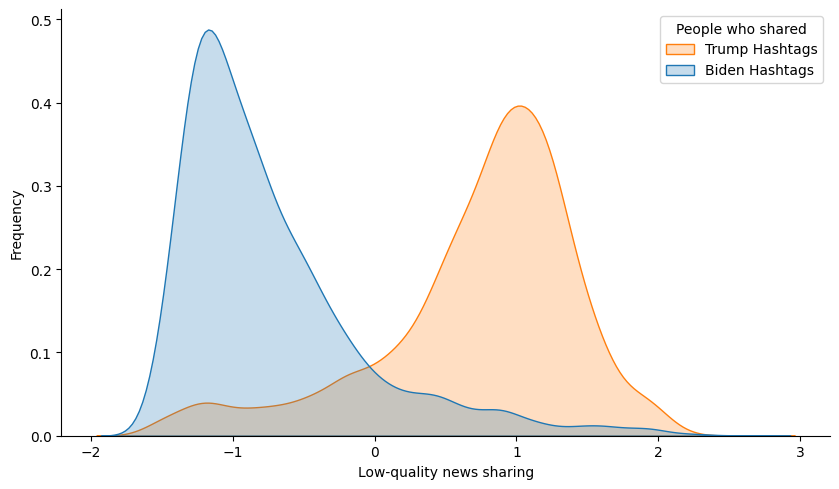

In [202]:
displot = sns.displot(
    hashtag_lowquality,
    x="lowqual_pr2019_crowd_SCALED",
    kind="kde",
    fill=True,
    hue="politics_hashtag",
    aspect=1.7,
    legend=False
)

plt.xlabel("Low-quality news sharing")
plt.ylabel("Frequency")
plt.grid(()) # remove gird
_ = plt.legend(title = "People who shared", labels = hashtag_labels)

* Is there an actual difference between the scores of Trump supporters, as opposed to Biden's?

* That being said, to figure out if the two means are unequal, although useful, is not enough information

* We would also like to know which mean is <i>greater</i>

* We can perform a $t$-test to figure that out, with the alternative hypothesis ($H_1$) being that one mean is greater than the other

* Lets divide the samples into the two respective groups

In [203]:
trump_scores = hashtag_lowquality.loc[hashtag_lowquality["politics_hashtag"] == 1, ["lowqual_pr2019_fc"]]
biden_scores = hashtag_lowquality.loc[hashtag_lowquality["politics_hashtag"] == 0, ["lowqual_pr2019_fc"]]

In [204]:
print(f"Trump std: {trump_scores['lowqual_pr2019_fc'].std()}\nBiden std: {biden_scores['lowqual_pr2019_fc'].std()}")

Trump std: 0.15196012121154384
Biden std: 0.14534279901301647


* The variances are almost identical, so we are good to perform the test

* If that were not the case, we would have to use [Welch's t-test](https://en.wikipedia.org/wiki/Welch's_t-test)

In [205]:
from scipy.stats import ttest_ind

ttest_model = ttest_ind(
    trump_scores,
    biden_scores,
    alternative="greater", # set H1 as: μ1 > μ2
    equal_var=True,
    nan_policy = "omit" # skip nans
)
print(f"t-test = {ttest_model.statistic[0]}\nPvalue = {ttest_model.pvalue[0]}")

t-test = 119.22334314832358
Pvalue = 0.0


* Using the same confidence level as before ($a$ = 5%), we reject the hypothesis that the samples have identical means

* That tells us, that Trump's score mean is greater than Biden's (the difference is significant)

* Lets also the check the confidence interval around the difference of the two means

In [206]:
confidence_int = ttest_model.confidence_interval(confidence_level=0.95)
print(f"[{confidence_int.low[0]}, {confidence_int.high[0]}]")

[0.36973456965801266, inf]


* We can be 95% sure that the difference of the two samples will fall under the above interval

## Effect

* We would like to extend the above analysis to some other features of our dataset

* Lets retrieve those features

In [207]:
complete_ratings = accounts[[
    "politics_hashtag",
    "lowqual_pr2019_fc",
    "lowqual_afm",
    "lowqual_mbfc",
    "lowqual_lasser2019",
    "lowqual_pr2019_crowd",
    "lowqual_pr2019_crowdrep"
]]
complete_ratings.head()

,politics_hashtag,lowqual_pr2019_fc,lowqual_afm,lowqual_mbfc,lowqual_lasser2019,lowqual_pr2019_crowd,lowqual_pr2019_crowdrep
0,0,0.279221,0.185315,0.292807,0.350000,0.598883,0.700800
1,1,0.848639,0.614156,0.513147,0.975087,0.774873,0.755118
2,0,0.242347,0.130950,0.242445,0.300000,0.548727,0.658118
3,0,0.360119,0.180055,0.277793,0.316038,0.611501,0.699165
4,1,0.698661,0.430655,0.554609,0.763889,0.700217,0.725429


* The different columns denote different rating sources

* We should create the two respective groups

In [208]:
political_groups = complete_ratings.groupby("politics_hashtag")

# drop the hashtag at it provides provides no information now per group
biden_complete_ratings = political_groups.get_group(0).drop(["politics_hashtag"], axis=1)
trump_complete_ratings = political_groups.get_group(1).drop(["politics_hashtag"], axis=1)

* Before executing the analysis, it would be useful to check if there exists any difference between the variances of the two groups in any category

In [209]:
biden_complete_ratings.std()

lowqual_pr2019_fc          0.145343
lowqual_afm                0.066149
lowqual_mbfc               0.085668
lowqual_lasser2019         0.101740
lowqual_pr2019_crowd       0.046797
lowqual_pr2019_crowdrep    0.026826
dtype: float64

In [210]:
trump_complete_ratings.std()

lowqual_pr2019_fc          0.151960
lowqual_afm                0.089488
lowqual_mbfc               0.078845
lowqual_lasser2019         0.164056
lowqual_pr2019_crowd       0.050954
lowqual_pr2019_crowdrep    0.028014
dtype: float64

* The differences are small enough for the variances to be considered 'equal', so we can continue with our analysis freely

In [211]:
ttest_model = ttest_ind(
    trump_complete_ratings,
    biden_complete_ratings,
    alternative="greater", # set H1 as: μ1 > μ2
    equal_var=True,
    nan_policy = "omit" # skip nans
)
ttest_model

TtestResult(statistic=array([119.22334315, 102.6777191 ,  97.59223108, 102.63374606,
       102.46401374,  61.07148517]), pvalue=array([0., 0., 0., 0., 0., 0.]), df=array([8943., 8996., 8997., 8997., 8943., 8943.]))

* Lets see the results more clearly

In [212]:
for i, col in enumerate(trump_complete_ratings.columns):
    print(f"{col}:")
    print(f"\tstatistic = {ttest_model.statistic[i]}, pvalue = {ttest_model.pvalue[i]}", end="\n\n")

lowqual_pr2019_fc:
	statistic = 119.22334314832358, pvalue = 0.0

lowqual_afm:
	statistic = 102.67771909991932, pvalue = 0.0

lowqual_mbfc:
	statistic = 97.59223108151366, pvalue = 0.0

lowqual_lasser2019:
	statistic = 102.63374606323765, pvalue = 0.0

lowqual_pr2019_crowd:
	statistic = 102.46401373884619, pvalue = 0.0

lowqual_pr2019_crowdrep:
	statistic = 61.07148517092751, pvalue = 0.0



* It appears that Trump's supporters score a significantly larger average rating from all rating sources

* That is, for confidence of 95%, because $p < 0.05, \; \forall \; p \in \text{Pvalues}$

* It that the end of the story, though?

* A difference in the averages, even if statistically significant, doesn't necessarily mean that it has a large $\it{effect}$

* That means that one average might be larger with statistical significance, but still be relatively close to the average of the second sample

* The difference between the averages of the samples can be denoted by how many standard deviations they differ from each other

* We will be using two metrics to calculate said difference. Cohen's $d$ and Hedge's $g$

* To calculate them, we will be using the `pingouin` library, as it provides implementations for both metrics 

In [213]:
import pingouin as pg

for col in trump_complete_ratings.columns:
    trump_ratings = trump_complete_ratings[col]
    biden_ratings = biden_complete_ratings[col]
    d = pg.compute_effsize(trump_ratings, biden_ratings, paired=False, eftype="cohen")
    g = pg.compute_effsize(trump_ratings, biden_ratings, paired=False, eftype="hedges")
    print(f"{col}:")
    print(f"\td = {d}, g = {g}", end="\n\n")

lowqual_pr2019_fc:
	d = 2.5211880897898826, g = 2.5209766457634544

lowqual_afm:
	d = 2.1648782742307926, g = 2.1646977824757223

lowqual_mbfc:
	d = 2.057540220941037, g = 2.057368697316872

lowqual_lasser2019:
	d = 2.1638306472835787, g = 2.1636502629241754

lowqual_pr2019_crowd:
	d = 2.166782479409766, g = 2.16660075825469

lowqual_pr2019_crowdrep:
	d = 1.291464380823202, g = 1.2913560698130968



* It looks like Trump's averages are not only significantly larger, but the difference also has an effect

* For `lowqual_pr2019_fc`, `lowqual_afm`, `lowqual_mbfc`, `lowqual_lasser2019` and `lowqual_pr2019_crowd`, which in turn denote the site ratings given by: fact-checker, Ad Fontes media, Media Bias/Fact Check, Laser et al. and USA citizens (971), the effect (std difference of averages) is huge

* The column `lowqual_pr2019_crowdrep` holds the site ratings, rated by the republican participants of the above USA citizens. 

* Cohen's $d$ is still very large (1.29) and so has a great effect, but the sudden decrease, might indicate a bias from the Trump supporters

* A way to interpret it, is that the republicans give a better rating (meaning a lower score) to the sites that they themselves often use, so a lower difference to the averages is seen

* If the above hypothesis were true, it is normal to expect the average rating of Trump supporters, be closer to the average rating of Biden's, that gets us a smaller $d$

* The quantitative way to interpret $d$, is that Trump's average rating is 1.29 standard deviations larger than Biden's (or 2.52 for the 8 fact checkers)

* Hedge's $g$ appears almost identical to $d$ in all cases, probably because both of the samples have a sufficient size

## Correlation

* To this point, we have analyzed the difference between the two supporter parties, as well as the effect of said difference 

* Continuing, it would be useful to check whether lower-quality news sources and political view, are correlated with each other (using our dataset as the basis) 

* Lets retrieve any information that would be relevant for the next steps of the analysis

* First, any attributes that reference the political affiliation of an account

In [214]:
politics = accounts[["politics_followed", "politics_hashtag", "politics_sites1", "politics_sites2"]]
politics.head()

,politics_followed,politics_hashtag,politics_sites1,politics_sites2
0,-0.080295,0,-1.168745,-0.231902
1,2.296375,1,1.060905,0.405261
2,-2.312730,0,-0.500076,-0.171067
3,-1.507481,0,-0.748035,-0.085814
4,2.010573,1,1.347730,0.595367


* And, of course, the news qualities measures

In [215]:
complete_ratings_no_hashtag = complete_ratings.drop("politics_hashtag", axis = 1)
complete_ratings_no_hashtag.head()

,lowqual_pr2019_fc,lowqual_afm,lowqual_mbfc,lowqual_lasser2019,lowqual_pr2019_crowd,lowqual_pr2019_crowdrep
0,0.279221,0.185315,0.292807,0.350000,0.598883,0.700800
1,0.848639,0.614156,0.513147,0.975087,0.774873,0.755118
2,0.242347,0.130950,0.242445,0.300000,0.548727,0.658118
3,0.360119,0.180055,0.277793,0.316038,0.611501,0.699165
4,0.698661,0.430655,0.554609,0.763889,0.700217,0.725429


* Before we continue, lets put a picture on our data, to maybe pick out a pattern or two 

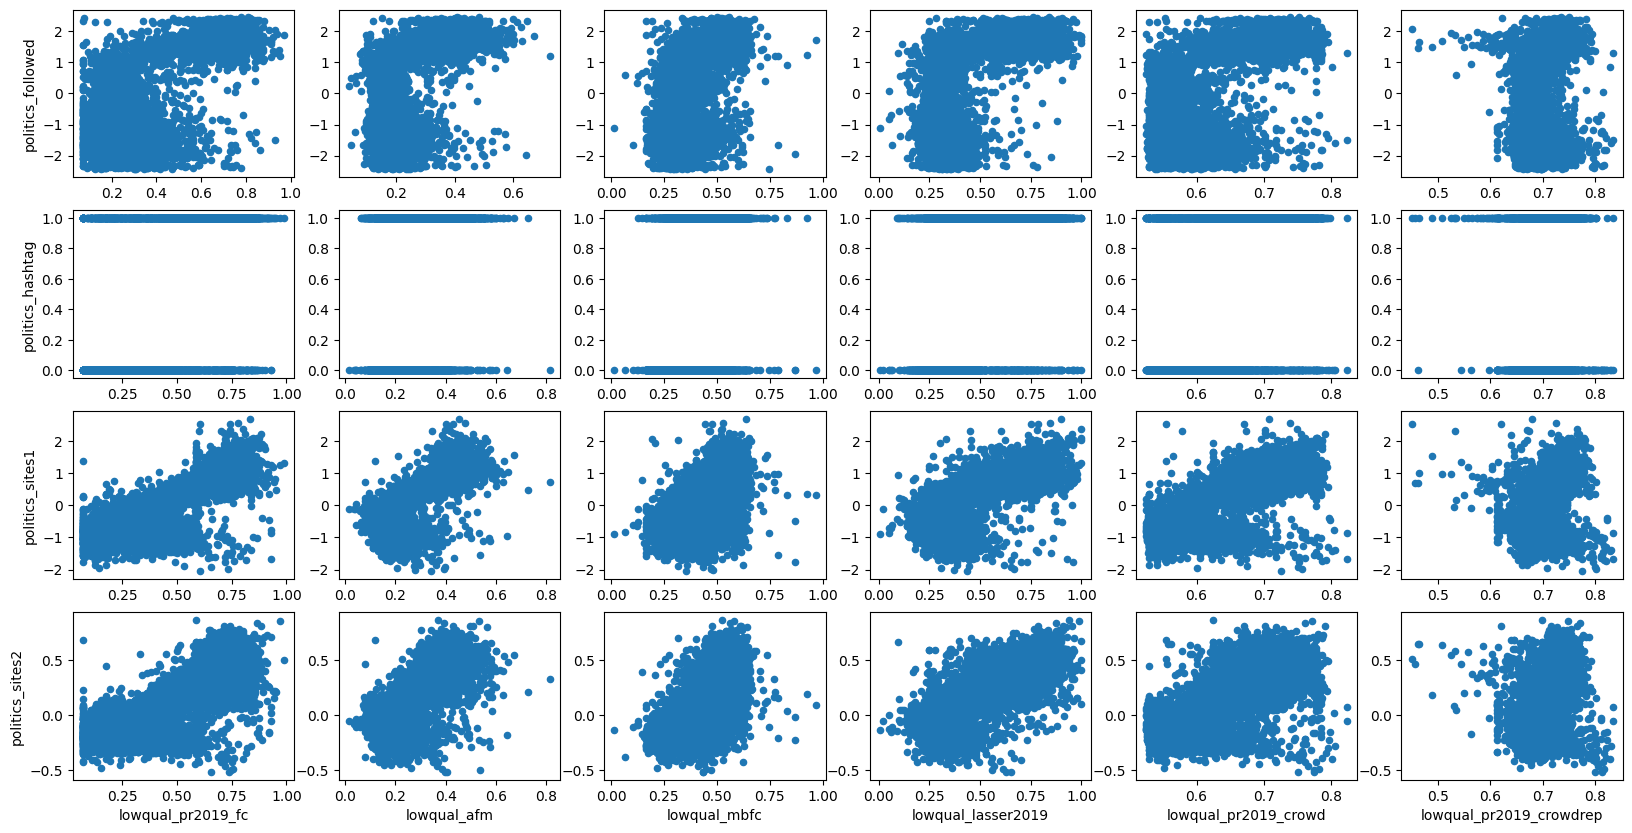

In [216]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20,10))

for row_index, row_label in enumerate(politics.columns):
    y = politics[row_label]
    for col_index, col_label in enumerate(complete_ratings_no_hashtag.columns):
        x = complete_ratings_no_hashtag[col_label]

        # get current axes
        ax = axes[row_index, col_index]

        # plot
        pd.concat([x, y], axis=1) \
            .plot.scatter(
                x=col_label,
                y=row_label,
                ax=ax, # draw on the current axes
                xlabel="",
                ylabel=""
            )

        # set axes labels only on grid plots
        if col_index == 0:
            ax.set_ylabel(row_label)
        if row_index == 3:
            ax.set_xlabel(col_label)

plt.show()

* At a first view, it would appear that some combinations are unrelated to each other

* We can pick out a kind of positive relationship between 
    * `lowqual_pr2019_fc`,
    * `lowqual_afm`,
    * `lowqual_lasser2019`
    * `lowqual_pr2019_crowd`

* And `politics_sites1` and `politics_sites2`

* But still, we can't reach to a solid conclusion by just looking at the graphical representations

* We will use Pearson's correlation coefficient, $r$

* We can be confident with our choice of correlation method, as it appears most of our data follow a linear relationship

* If we suspected that that was not the case, we would also test Spearman's $r$

* Lets create the structure of the data we want to check

In [217]:
correlation_matrix = pd.concat([politics, complete_ratings_no_hashtag], axis=1) \
    .corr(method = "pearson") \
    .drop(["lowqual_pr2019_fc", "lowqual_afm", "lowqual_mbfc",  # remove unneeded columns
        "lowqual_lasser2019", "lowqual_pr2019_crowd", "lowqual_pr2019_crowdrep"], axis = 1) \
    .drop(["politics_followed","politics_hashtag","politics_sites1","politics_sites2"], axis = 0) # remove unneeded columns
correlation_matrix

,politics_followed,politics_hashtag,politics_sites1,politics_sites2
lowqual_pr2019_fc,0.809501,0.783463,0.876237,0.854197
lowqual_afm,0.768887,0.734562,0.845285,0.833632
lowqual_mbfc,0.748146,0.717101,0.774779,0.774266
lowqual_lasser2019,0.777250,0.734398,0.835576,0.851794
lowqual_pr2019_crowd,0.754001,0.734856,0.811904,0.784861
lowqual_pr2019_crowdrep,0.540993,0.542505,0.576336,0.552613


* Lets also display it with more colors

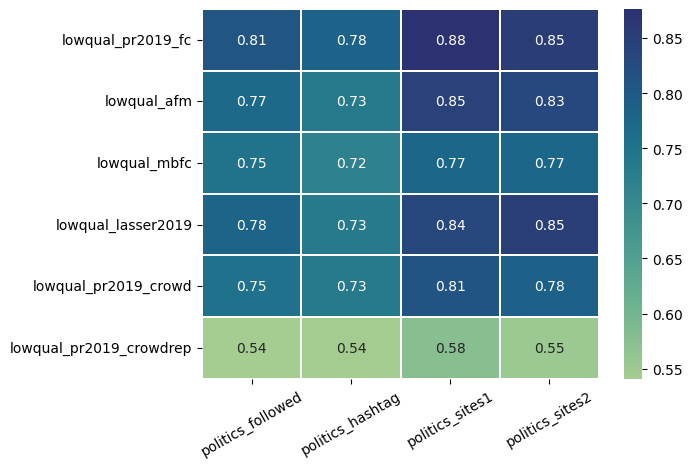

In [218]:
sns.heatmap(correlation_matrix, annot = True, cmap = "crest", linewidths = 0.1)
_ = plt.xticks(rotation = 30) # rotate x labels

* Pearson's $r$ agrees with out initial thought, as it appears the positive relationships are largest in the combinations we suspected

* The method also revealed various other relationships that perhaps we would have missed if we just sticked to the diagrams

* Using the basis of the above methods of correlation, we can say with confidence that lower-quality news sharing is positively related with conservative ideology (as we have many $r$ > 0.7)

* Most of the rating sources, once again, have not many differences with each other on the same variables

* More specifically, if we ignore the last row:
    * `politics_followed` $r$ $\in$ [0.75, 0.81]
    * `politics_hashtag` $r$ $\in$ [0.73, 0.78]
    * `politics_sites1` $r$ $\in$ [0.77, 0.88]
    * `politics_sites2` $r$ $\in$ [0.77, 0.85]

* But again, the site ratings coming from opinions of republicans, appear way less related to conservative ideology

* That means that if we used said group's opinion as a basis, we would reach the conclusion that being 'more' conservative has less of an effect to the sharing of lower-quality news sources (but still exists has a positive effect as all $r$ > 0)

## Forecasting

### Single Predictors

* Thus far, we have only been interested in descriptive measures 

* We are now ready to take it up a notch, by moving to predictive statistics

* What we will aim for, is to see if we can predict wether an account will get suspended 

* To do that, we will use as information its political orientation, as well as its various ratings based on the sources we have already talked about

* Lets retrieve the above predictors

In [219]:
predictors = pd.concat([
        politics,
        complete_ratings_no_hashtag.drop(["lowqual_pr2019_crowdrep"],axis = 1).dropna()
    ], axis = 1
)
predictors.head()

,politics_followed,politics_hashtag,politics_sites1,politics_sites2,lowqual_pr2019_fc,lowqual_afm,lowqual_mbfc,lowqual_lasser2019,lowqual_pr2019_crowd
0,-0.080295,0,-1.168745,-0.231902,0.279221,0.185315,0.292807,0.350000,0.598883
1,2.296375,1,1.060905,0.405261,0.848639,0.614156,0.513147,0.975087,0.774873
2,-2.312730,0,-0.500076,-0.171067,0.242347,0.130950,0.242445,0.300000,0.548727
3,-1.507481,0,-0.748035,-0.085814,0.360119,0.180055,0.277793,0.316038,0.611501
4,2.010573,1,1.347730,0.595367,0.698661,0.430655,0.554609,0.763889,0.700217


* To execute the predictions, we will use a $Probit$ regression model

* For practical reasons, the reader can think of the model as a variation of logistic regression (called logit)

* The difference of probit, when compared with logit, is its use of the inverse of the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) as the link function

* For a more detailed explanation, the reader is advised to check [probit model](https://en.wikipedia.org/wiki/Probit_model)

* We will start our forecasting by trying to predict a suspension, based on a $single$ predictor

* But we will need to answer the following question: how can we evaluate between different predictors, to know which one to pick?

* Various evaluation methods exist, but we will stick to the AUC of the ROC as our evaluation criteria

* The ROC curve of a prediction model, is the line that gets formed when the independent variable is the False Positive Rate, and the dependant, the True Positive Rate

* The AUC, is simply the area covered under the ROC

* A model with a good prediction history, will have a larger AUC score

* The maximum score is equal to 1

* To test our models, we will get them to predict a suspension (Y), using the same values (X) that we used for fitting

* Lets check the AUC of our different predictors

In [220]:
from statsmodels.discrete.discrete_model import Probit
from statsmodels.tools import add_constant
from sklearn.metrics import roc_auc_score

auc_results = dict()

print("pvalues:\n\tpredictor | intercept | exog variable")
for predictor in predictors.columns:
    # create temp dataframe to completely remove nans
    temp = pd.concat([accounts["suspended"], predictors[predictor]], axis = 1).dropna()

    # fit regression model on full dataset
    probit_model = Probit(temp["suspended"], add_constant(temp[predictor])).fit(disp = False) # silence verbose

    print(f"\t{predictor}", end=" ")
    for pvalue in probit_model.pvalues:
        print(f"\t{pvalue}", end=" ")
    print()

    # save evaluation results of model predictions
    auc_results[predictor] = roc_auc_score(y_true = temp["suspended"], y_score = probit_model.predict())

auc_results = pd.DataFrame(
    auc_results.items(),
    columns = ["predictor", "auc"]
)

pvalues:
	predictor | intercept | exog variable
	politics_followed 	0.0 	5.242903230689675e-90 
	politics_hashtag 	0.0 	2.7998648842714855e-103 
	politics_sites1 	0.0 	2.741576426106363e-106 
	politics_sites2 	0.0 	9.149510025755729e-110 
	lowqual_pr2019_fc 	0.0 	1.3102236384111418e-102 
	lowqual_afm 	0.0 	2.7022260242768716e-113 
	lowqual_mbfc 	8.68195553842913e-272 	4.0891551782673717e-101 
	lowqual_lasser2019 	0.0 	3.344296580411762e-107 
	lowqual_pr2019_crowd 	2.9853477156816417e-153 	4.9905920241336375e-89 


* By taking a peak at the pvalues of the coefficients of the different predictors (as well as the respective intercept in each model), we can say with confidence that they are all significant (< 0.05)

* That is, when they are used alone in a model

* That tells us that each model is a good representative of the population, but doesn't say much for the actual quality of the models

* We need to derive that from the AUC scores

In [221]:
auc_results

,predictor,auc
0,politics_followed,0.715641
1,politics_hashtag,0.678796
2,politics_sites1,0.700531
3,politics_sites2,0.704819
4,lowqual_pr2019_fc,0.698401
5,lowqual_afm,0.715227
6,lowqual_mbfc,0.706449
7,lowqual_lasser2019,0.704945
8,lowqual_pr2019_crowd,0.685669


* It appears that the models formed using the single predictors, achieve good prediction power

* We can reach that conclusion because all AUC $\in (0.67, 0.72)$ (all scores are close to 1)

* But we are also interested in the predictive power of the rating sources, when compared with the political orientations

* Lets take the averages to get an estimation

In [222]:
print(f"political orientation = {auc_results.iloc[:4]['auc'].mean()}\nLow-quality news sharing = {auc_results.iloc[4:]['auc'].mean()}")

political orientation = 0.6999470407874572
Low-quality news sharing = 0.7021380835311405


* It's pretty clear that these two predictor categories have almost identical predictive powers 

* To put it more simply, if we wanted to predict whether an account will get suspended, using $one$ predictor, we can use either their political orientation, or the ratings they received

* Next to the AUC scores, it would be also useful to see a confidence interval, for the values they can take

* In order to achieve that, we would have to fit every model multiple times, each time with a different training set (because if we fitted using the same training set, we would get the same results)

* The training sets we will use, will be different subsets of the starting data set, that are chosen using stochastic sampling with replacement 

* By fitting each model various times, we will get slightly different models, that we can again evaluate using the AUC  

* Using the different AUC scores that were harvested, we can draw a confidence interval to get a better understanding of each model's power

* The process we just described, is called $bootstrapping$

* Using bootstrapping, lets create confidence intervals for each predictor, by creating 100 different estimators for each one

In [223]:
from scipy.stats import bootstrap

# return auc score of probit prediction fitted on subset denoted by indices
def probit_auc(indices):
    temp_model = Probit(temp.loc[indices, "suspended"], add_constant(temp.loc[indices, predictor])).fit(disp = False)
    return roc_auc_score(y_true = temp.loc[indices, "suspended"], y_score = temp_model.predict())

n_estimators = 100
predictor_results = dict()

for predictor in predictors.columns:
    # create temp dataframe to completely remove nans
    temp = pd.concat([accounts["suspended"], predictors[predictor]], axis = 1).dropna()

    # fit regression model on full dataset
    probit_model = Probit(temp["suspended"], add_constant(temp[predictor])).fit(disp = False) # silence verbose

    # execute 100 estimators on bootstrap pipeline
    bootstrap_pipe = bootstrap(
        (temp.index,),
        probit_auc,
        confidence_level = 0.95,
        method = 'percentile',
        n_resamples = n_estimators
    )

    # save evaluation of model
    predictor_results[predictor] = {
        "auc": roc_auc_score(y_true = temp["suspended"], y_score = probit_model.predict()),
        "conf": (bootstrap_pipe.confidence_interval[0], bootstrap_pipe.confidence_interval[1])
    }

# calculate the range for each conf interval
predictors_results = pd.DataFrame(
    ((predictor, data["auc"], data["conf"][0], data["conf"][1]) for predictor, data in predictor_results.items()),
    columns = ["predictor", "auc", "conf_lb", "conf_ub"]
)
predictors_results

,predictor,auc,conf_lb,conf_ub
0,politics_followed,0.715641,0.699405,0.736021
1,politics_hashtag,0.678796,0.669116,0.687378
2,politics_sites1,0.700531,0.683534,0.715443
3,politics_sites2,0.704819,0.686749,0.725204
4,lowqual_pr2019_fc,0.698401,0.684021,0.712205
5,lowqual_afm,0.715227,0.698179,0.728417
6,lowqual_mbfc,0.706449,0.692425,0.721432
7,lowqual_lasser2019,0.704945,0.693080,0.720980
8,lowqual_pr2019_crowd,0.685669,0.671820,0.702542


* As we can see, we now have lower and upper limits on our evaluations

* This gives us much better confidence about the quality of each predictor

* Lets paint the above findings so we can get a better look

* We should first distribute the predictors into respective classes, so we can differentiate them in the future chart 

In [224]:
predictors_results["class"] = "Low-quality news sharing"
predictors_results.loc[:3, "class"] = "Political orientation"
predictors_results

,predictor,auc,conf_lb,conf_ub,class
0,politics_followed,0.715641,0.699405,0.736021,Political orientation
1,politics_hashtag,0.678796,0.669116,0.687378,Political orientation
2,politics_sites1,0.700531,0.683534,0.715443,Political orientation
3,politics_sites2,0.704819,0.686749,0.725204,Political orientation
4,lowqual_pr2019_fc,0.698401,0.684021,0.712205,Low-quality news sharing
5,lowqual_afm,0.715227,0.698179,0.728417,Low-quality news sharing
6,lowqual_mbfc,0.706449,0.692425,0.721432,Low-quality news sharing
7,lowqual_lasser2019,0.704945,0.693080,0.720980,Low-quality news sharing
8,lowqual_pr2019_crowd,0.685669,0.671820,0.702542,Low-quality news sharing


* Also define some basic properties to make the chart look more appealing

In [225]:
# set colors based on predictor class
colors = {
    "Political orientation": "purple",
    "Low-quality news sharing": "green"
}

# rename predictors
bar_labels = {
    "politics_followed": "Accounts\nfollowed",
    "politics_hashtag": "Hashtag \nShared",
    "lowqual_pr2019_crowd": "Layperson \nratings",
    "lowqual_lasser2019": "Lasser\n ratings",
    "lowqual_mbfc": "MFBC \nratings",
    "lowqual_afm": "AFM \nratings",
    "lowqual_pr2019_fc": "Fact-\nChecker\n ratings",
    "politics_sites2": "News \nsites\n shared 2",
    "politics_sites1": "News\n sites\n shared 1"
}

* And, finally, paint the picture

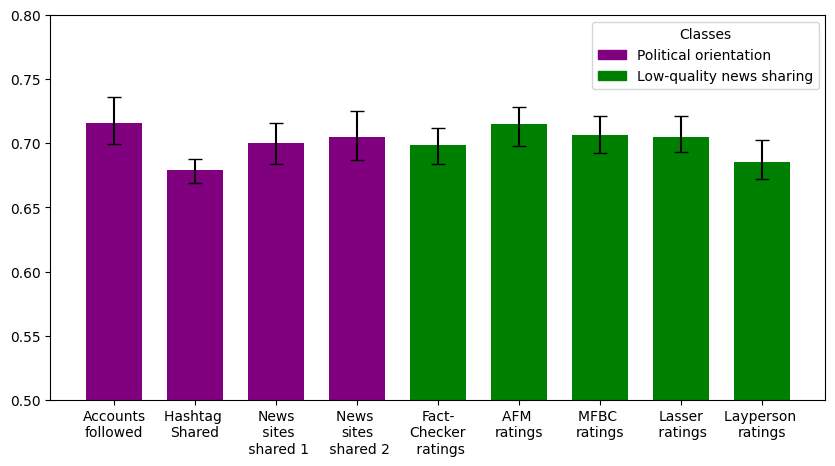

In [226]:
from matplotlib.patches import Patch

# define bar labels
predictor_labels = [bar_labels[p] for p in predictors_results["predictor"]]

# define bar colors
predictor_colors = [colors[c] for c in predictors_results["class"]]

# define bar confidence intervals
predictor_conf = [
    predictors_results["auc"] - predictors_results["conf_lb"],
    predictors_results["conf_ub"] - predictors_results["auc"]
]

figure, ax = plt.subplots(figsize = (10,5))

# draw chart
ax.bar(
    predictors_results["predictor"],
    predictors_results["auc"],
    yerr = predictor_conf,
    capsize = 5,
    width = 0.7,
    tick_label = predictor_labels,
    color = predictor_colors
)

# define patches for legend
handles = [Patch(color=color, label=label) for label, color in colors.items()]

ax.set_ylim(0.5, 0.8)
_ = ax.legend(handles=handles, title="Classes")

### Multiple Predictors

* We have witnessed that you can achieve good prediction power (with significance), using many - single - predictors

* If we wanted to use just one variable to make our predictions, we have the luxury of choosing from a vast set, with not too many expected differences

* Why stop there?

* By combining the knowledge of multiple predictors, perhaps we can achieve greater results

* Before continuing that thought, lets start with some data preprocessing

* Lets fill any missing values with the respective mean of the available observations from the accounts

In [227]:
accounts_cleaned = accounts.fillna(accounts.mean())
accounts_cleaned.head()

,politics_sites2,politics_sites1,politics_followed,lowqual_pr2019_crowd,lowqual_pr2019_fc,lowqual_afm,lowqual_mbfc,lowqual_lasser2019,suspended,politics_hashtag,...,valence_neg,valence_neu,valence_pos,politics_sites2_ideo_std,hashtag_ideo_std,barbera_std,politics_sites1_std,repeated_tweet_count,freq_pr_1h,bad_domain_count
0,-0.231902,-1.168745,-0.080295,0.598883,0.279221,0.185315,0.292807,0.350000,0,0,...,0.109935,0.813230,0.076835,0.274317,0.0,0.909460,69,86.0,30,7
1,0.405261,1.060905,2.296375,0.774873,0.848639,0.614156,0.513147,0.975087,0,1,...,0.115985,0.793715,0.090250,0.351800,0.0,0.157056,623,133.0,26,20
2,-0.171067,-0.500076,-2.312730,0.548727,0.242347,0.130950,0.242445,0.300000,0,0,...,0.085765,0.817340,0.096915,0.279591,0.0,0.445349,32,3.0,3,6
3,-0.085814,-0.748035,-1.507481,0.611501,0.360119,0.180055,0.277793,0.316038,0,0,...,0.108680,0.781135,0.110190,0.290277,0.0,0.256665,55,104.0,29,22
4,0.595367,1.347730,2.010573,0.700217,0.698661,0.430655,0.554609,0.763889,0,1,...,0.065145,0.860550,0.074320,0.300823,0.0,0.431149,37,36.0,8,8


* This way, we retain valuable data that were already available (as opposed to dropping them), while still, keeping our data close to the ordinary

* We will also use some of the tweeter metrics for each account

* But first, we should log transform them using base 10

In [228]:
accounts_cleaned[[
    "log_repeated_tweet_count",
    "log_freq_pr_1h",
    "log_num_followers",
    "log_num_friends"]] = np.log10(
                            accounts_cleaned[[
                                "repeated_tweet_count",
                                "freq_pr_1h",
                                "num_followers",
                                "num_friends"
                            ]] + 1  # add 1 to avoid log(0)
                        )

* Lets also introduce a new variable, that will denote the ratio of friends over follower of an account (and log transform again)

In [ ]:
accounts_cleaned["log_fol"] = np.log10(
    (accounts_cleaned["num_friends"] + 1) / # add 1 to avoid log(0)
    (accounts_cleaned["num_followers"] + 1)  # add 1 to avoid div(0)
)

* Our original data might be susceptible to outliers

* Outliers often influence analyses negatively, so we will try to avoid them wherever we can

* So how will we?

* We will use [winsorization](https://en.wikipedia.org/wiki/Winsorizing)

* The way it works, is that it resets outliers to a specified percentile (upper or lower) of the data

* Because of some specific properties of the data, we will use different percentiles for different features

* The first group will be winsorized from both sides at the top 1%

In [230]:
winsorized_cols = [
    "valence_neg",
    "valence_neu",
    "valence_pos",
    "barbera_std",
    "politics_sites1_std",
    "politics_sites2_ideo_std"
]

accounts_cleaned[winsorized_cols] = \
        accounts_cleaned[winsorized_cols].apply(
                stats.mstats.winsorize,
                limits=(0.01, 0.01) # winsorize from both sides, top 1%
        )

* The second set of features will get winsorized from the upper side, again at the top 1% 

In [231]:
winsorized_cols = [
    "moral_outrage",
    "rewire_abuse",
    "rewire_hate",
    "rewire_profanity",
    "rewire_violent",
    "rewire_sexually_explicit",
    "jigsaw_toxicity",
    "jigsaw_severe_toxicity",
    "jigsaw_idenity_attack",
    "jigsaw_insult",
    "jigsaw_profanity",
    "jigsaw_threat"
]

accounts_cleaned[winsorized_cols] = \
        accounts_cleaned[winsorized_cols].apply(
                stats.mstats.winsorize,
                limits=(0, 0.01) # winsorize from upper side, top 1%
        )

* We will use the following features for our predictions (and some others)

In [232]:
normalized_cols = [
    "lowqual_pr2019_fc",
    "lowqual_afm",
    "lowqual_lasser2019",
    "lowqual_mbfc",
    "politics_hashtag",
    "politics_followed",
    "politics_sites1",
    "politics_sites2",
    "log_num_followers",
    "log_num_friends",
    "log_fol",
    "rewire_abuse",
    "rewire_hate",
    "rewire_profanity",
    "rewire_violent",
    "rewire_sexually_explicit",
    "jigsaw_toxicity",
    "jigsaw_severe_toxicity",
    "jigsaw_idenity_attack",
    "jigsaw_insult",
    "jigsaw_profanity",
    "jigsaw_threat",
    "valence_neg",
    "valence_neu",
    "valence_pos"
]

* They're a lot

* Many of these features explain a similar theme

* For example, `lowqual_pr2019_fc`, `lowqual_afm`, `lowqual_lasser2019` and `lowqual_mbfc` explain the low-quality news sharing scores of an account 

* Perhaps we can 'merge' these groups into principle components, so we can describe the same information (with some minimal loss), using less variables

* We will use PCA to do that

* From an experimental empirical analysis, we know that we should create:
    * 1 PC for `lowqual_pr2019_fc`, `lowqual_afm`, `lowqual_lasser2019`, `lowqual_mbfc` <br><br>
    * 1 PC for `politics_hashtag`, `politics_followed`, `politics_sites1`, `politics_sites2` <br><br>
    * 1 PC for `log_followers`, `log_friends`, `log_fol` <br><br>
    * 3 PC for `rewire_abuse`, `rewire_hate`, `rewire_profanity`, `rewire_violent`, `rewire_sexually_explicit`, `jigsaw_toxicity`, `jigsaw_severe_toxicity`, `jigsaw_idenity_attack`, `jigsaw_insult`, `jigsaw_profanity`, `jigsaw_threat` <br><br>
    * 1 PC for `valence_neg`, `valence_neu`, `valence_pos`

* We should remember that PCA is influenced by the variances of the original features

In [233]:
accounts_cleaned[normalized_cols].std()

lowqual_pr2019_fc           0.238542
lowqual_afm                 0.115966
lowqual_lasser2019          0.201139
lowqual_mbfc                0.118104
politics_hashtag            0.500027
politics_followed           1.467387
politics_sites1             0.896221
politics_sites2             0.305400
log_num_followers           0.816299
log_num_friends             0.640642
log_fol                     0.435208
rewire_abuse                0.056932
rewire_hate                 0.027449
rewire_profanity            0.037159
rewire_violent              0.013846
rewire_sexually_explicit    0.004712
jigsaw_toxicity             0.043723
jigsaw_severe_toxicity      0.013099
jigsaw_idenity_attack       0.018955
jigsaw_insult               0.043116
jigsaw_profanity            0.028581
jigsaw_threat               0.010623
valence_neg                 0.019413
valence_neu                 0.035437
valence_pos                 0.026785
dtype: float64

* It would be wrong to apply PCA directly on the above data, as many of them have different variances (because of their respective scale)

* We should first standardize them

In [234]:
accounts_cleaned[normalized_cols] = StandardScaler().fit_transform(
    accounts_cleaned[normalized_cols]
)

* Now all of the features have a variance of 1

In [235]:
accounts_cleaned[normalized_cols].std()

lowqual_pr2019_fc           1.000056
lowqual_afm                 1.000056
lowqual_lasser2019          1.000056
lowqual_mbfc                1.000056
politics_hashtag            1.000056
politics_followed           1.000056
politics_sites1             1.000056
politics_sites2             1.000056
log_num_followers           1.000056
log_num_friends             1.000056
log_fol                     1.000056
rewire_abuse                1.000056
rewire_hate                 1.000056
rewire_profanity            1.000056
rewire_violent              1.000056
rewire_sexually_explicit    1.000056
jigsaw_toxicity             1.000056
jigsaw_severe_toxicity      1.000056
jigsaw_idenity_attack       1.000056
jigsaw_insult               1.000056
jigsaw_profanity            1.000056
jigsaw_threat               1.000056
valence_neg                 1.000056
valence_neu                 1.000056
valence_pos                 1.000056
dtype: float64

* Lets now continue with the PCA, starting with the misinformation columns

In [236]:
from sklearn.decomposition import PCA

misinfo_pca_model = PCA(n_components=1).fit(
    accounts_cleaned[[
        "lowqual_pr2019_fc",
        "lowqual_afm",
        "lowqual_lasser2019",
        "lowqual_mbfc"
]])

* We managed to explain the low-quality news sharing data pretty well:

In [237]:
misinfo_pca_model.explained_variance_ratio_

array([0.87255953])

* That means that the new feature (composed from the original 4) explains 87% of the original's data variance

* Lets project the old dimensions into the new one (that we will call `pc1_misinfo`)

In [238]:
accounts_cleaned["pc1_misinfo"] = misinfo_pca_model.transform(
    accounts_cleaned[[
        "lowqual_pr2019_fc",
        "lowqual_afm",
        "lowqual_lasser2019",
        "lowqual_mbfc"
]])

* Continuing with the politics dimensions

In [239]:
politics_pca_model = PCA(n_components=1).fit(
    accounts_cleaned[[
        "politics_hashtag",
        "politics_followed",
        "politics_sites1",
        "politics_sites2"
]])

* And the explained variance ratio of the principle component

In [240]:
politics_pca_model.explained_variance_ratio_

array([0.87952937])

* It appears that by using one component instead of four, we can explain the variance of the politics measures, in the same level (about 88%) as we can with the low-quality news ratings

* The new component will be called `pc1_politics`

In [241]:
accounts_cleaned["pc1_politics"] = politics_pca_model.transform(
    accounts_cleaned[[
        "politics_hashtag",
        "politics_followed",
        "politics_sites1",
        "politics_sites2"
]])

* We will also need a new variable that takes as values, the absolute value of `pc1_politics`

* The `extremity` denotes a user’s extent of ideological extremity 

In [242]:
accounts_cleaned["extremity"] = np.abs(accounts_cleaned["pc1_politics"])

* For our third set of features, we will once again create a single principle component

In [243]:
fol_pca_model = PCA(n_components=1).fit(
    accounts_cleaned[[
        "log_num_followers",
        "log_num_friends",
        "log_fol",
]])
fol_pca_model.explained_variance_ratio_

array([0.70462969])

* We can explain only 70% of these three features using a single component, it seems

* That means that we lost more information when we went from multiple features to one, in the tweeter metrics, than when we made the same move with `pc1_politics` or `pc1_misinfo`

* We will reference the tweeter metrics as `pc1_fol`

In [244]:
accounts_cleaned["pc1_fol"] = fol_pca_model.transform(
    accounts_cleaned[[
        "log_num_followers",
        "log_num_friends",
        "log_fol",
]])

* For our next set, that contains the features for harmful language, we will create three principle components

In [245]:
hl_pca_model = PCA(n_components=3).fit(
    accounts_cleaned[[
        "rewire_abuse",
        "rewire_hate",
        "rewire_profanity",
        "rewire_violent",
        "rewire_sexually_explicit",
        "jigsaw_toxicity",
        "jigsaw_severe_toxicity",
        "jigsaw_idenity_attack",
        "jigsaw_insult",
        "jigsaw_profanity",
        "jigsaw_threat"
    ]]
)
hl_pca_model.explained_variance_ratio_

array([0.5616608 , 0.11871792, 0.10703707])

* The first PC explains 56% of the data's variance, the second PC, 11.8% and the third, 10.7%

* When creating PCs, it is normal for the explained variance to drop with each component

* That's because each component tries to explain the variance that the last one failed to

* In total, we have:

In [246]:
hl_pca_model.explained_variance_ratio_.sum()

np.float64(0.7874157847381196)

* But why use three components, instead of one? Lets try to interpret them

In [247]:
hl_pca_model.components_

array([[ 0.32530845,  0.23538337,  0.25255674,  0.23252186,  0.12526899,
         0.38547179,  0.33586086,  0.30692208,  0.37440778,  0.3617071 ,
         0.28039267],
       [ 0.34409751,  0.5765375 , -0.23191386,  0.06740265, -0.53686584,
         0.13232154, -0.30099609, -0.04947252,  0.13741195, -0.20511297,
        -0.17646751],
       [-0.30773448, -0.03195551, -0.43039704, -0.03699539, -0.37270948,
        -0.07810217,  0.24571418,  0.46254153, -0.03715369, -0.15336206,
         0.52291043]])

* Each PC is a linear combination of the original features

* That means that the first PC is equal to $0.32 * X_1 + 0.23 * X_2 + ...$

* The third PC is equal to $-0.3 * X_1 -0.03 * X_2 + ...$

* Where $X_1$ is `rewire_abuse`, $X_2$ `rewire_hate` and so on

* As we can see, the first component gives similar weights (called loadings) to all the original features, with the larger load given to `jigsaw_toxicity`

* We know from the [documentation](https://developers.perspectiveapi.com/s/about-the-api-training-data?language=en_US) of the jigsaw API that 'toxic' is any language that is "rude, disrespectful, unreasonable, or otherwise somewhat likely to make a user leave a discussion or give up on sharing their perspective"

* So we might reach the conclusion that the first PC captures the knowledge of general $\textit{toxicity}$ (as it gives similar loadings to insults, profanity etc)

* The second PC gives the heavier loads to `rewire_hate` and `rewire_sexually_explicit` (on the negative side)

* We know from rewire's [demo](https://www.youtube.com/watch?v=tmQWXHIScfs&ab_channel=RewireOnline) of the API, that they define 'hate' as "abuse targeted at protected groups or characteristics such as gender, race or religion"

* The second PC probably captures the information of sexually abusive language (as it gives some generous weight to `rewire_abuse` as well)

* The last PC gives sufficient weights to `jigsaw_threat`, `jigsaw_idenity_attack` and `rewire_profanity` (on the negative side)

* From this [page](https://support.perspectiveapi.com/s/about-the-api-attributes-and-languages?language=en_US) of documentation, we understand that 'identity_attack' means "negative or hateful comments targeting someone because of their identity", while 'threat' describes "an intention to inflict pain, injury, or violence against an individual or group"

* The third PC mostly captures information of aggression and profane language

* If we kept only the first PC, we would not be able to distinguish between the different kinds of harmful language, and would not manage to explain their variances

* Projection:

In [248]:
accounts_cleaned[["pc1_harmful_language",
                "pc2_harmful_language",
                "pc3_harmful_language"]] = hl_pca_model.transform(
                        accounts_cleaned[[
                            "rewire_abuse",
                            "rewire_hate",
                            "rewire_profanity",
                            "rewire_violent",
                            "rewire_sexually_explicit",
                            "jigsaw_toxicity",
                            "jigsaw_severe_toxicity",
                            "jigsaw_idenity_attack",
                            "jigsaw_insult",
                            "jigsaw_profanity",
                            "jigsaw_threat"
                        ]]
                )

* And we finish with the last set

In [249]:
val_pca_model = PCA(n_components=1).fit(
    accounts_cleaned[[
        "valence_neg",
        "valence_neu",
        "valence_pos"
    ]]
)
val_pca_model.explained_variance_ratio_

array([0.7079432])

* After conducting all the PCAs, its obvious that the variables that are harder to explain using a single feature, are `log_followers`, `log_friends`, `log_fol` (the PC has the smallest explained variance ratio)

In [250]:
accounts_cleaned["pc1_valence"] = val_pca_model.transform(
    accounts_cleaned[[
        "valence_neg",
        "valence_neu",
        "valence_pos"
    ]]
)

* What did we achieve?

* We managed to reduce the number of independent variables of our future regression

* Now we can use all of the above components, as well as the rest of the features we would like to use as predictors, in a probit

* Now that we have a new set of features (because of the PCAs), we should check the variances of the resulting features (and the other ones we will use for the regression)

In [251]:
normalized_cols = [
    "pc1_politics",
    "pc1_misinfo",
    "pc1_fol",
    "pc1_harmful_language",
    "pc2_harmful_language",
    "pc3_harmful_language",
    "pc1_valence",
    "tweets_in_2wk",
    "botsentinel_score",
    "extremity",
    "moral_outrage",
    "liwc_political",
    "log_freq_pr_1h",
    "log_repeated_tweet_count",
    "barbera_std",
    "politics_sites1_std",
    "politics_sites2_ideo_std"
]

accounts_cleaned[normalized_cols].std()

pc1_politics                  1.875769
pc1_misinfo                   1.868322
pc1_fol                       1.454003
pc1_harmful_language          2.485750
pc2_harmful_language          1.142822
pc3_harmful_language          1.085145
pc1_valence                   1.457417
tweets_in_2wk               990.761184
botsentinel_score            20.393098
extremity                     0.560697
moral_outrage                 0.061418
liwc_political                0.145147
log_freq_pr_1h                0.347347
log_repeated_tweet_count      0.697156
barbera_std                   0.287247
politics_sites1_std          70.982196
politics_sites2_ideo_std      0.068959
dtype: float64

* Lets standardize one final time, before the regression

In [252]:
accounts_cleaned[normalized_cols] = StandardScaler().fit_transform(accounts_cleaned[normalized_cols])

* We are now free to perform the probit on the above independent variables

In [253]:
probit_model = Probit(
    accounts_cleaned["suspended"],
    add_constant(accounts_cleaned[normalized_cols]) # add intercept
).fit(disp = False)

* Lets see a summary of our model

In [254]:
probit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              suspended   No. Observations:                 9000
Model:                         Probit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.1762
Time:                        19:44:53   Log-Likelihood:                -2723.7
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                3.877e-237
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.4273      0.023    -61.086      0.000      -1.473      -1.381
pc1_politics                 0.1341      0.053      2.535      0.011       0.030       0.238
pc1_misinfo                  0.2448      0.046      5.265      0.000       0.154       0.336
pc1_fol                      0.0013      0.021      0.064      0.949      -0.040       0.042
pc1_harmful_language         0.1761      0.026      6.750      0.000       0.125       0.227
pc2_harmful_language        -0.0830      0.026     -3.226      0.001      -0.133      -0.033
pc3_harmful_language        -0.0662      0.021     -3.216      0.001      -0.107      -0.026
pc1_valence                  0.0410      0.023      1.819      0.069      -0.003       0.085
tweets_in_2wk                0.3316      0.021     15.934      0.000       0.291       0.372
botsentinel_score            0.1825      0.039      4.724      0.000       0.107       0.258
extremity                   -0.1199      0.023     -5.295      0.000      -0.164      -0.076
moral_outrage                0.0170      0.034      0.501      0.616      -0.049       0.083
liwc_political              -0.0226      0.029     -0.790      0.429      -0.079       0.033
log_freq_pr_1h               0.1222      0.023      5.351      0.000       0.077       0.167
log_repeated_tweet_count    -0.0074      0.023     -0.326      0.745      -0.052       0.037
barbera_std                 -0.0303      0.024     -1.276      0.202      -0.077       0.016
politics_sites1_std         -0.0259      0.021     -1.224      0.221      -0.067       0.016
politics_sites2_ideo_std     0.0612      0.022      2.752      0.006       0.018       0.105
============================================================================================
"""

* Before interpreting the results of the probit, we should be careful

* Since we used multiple regression, with multiple hypotheses (one for each independent variable + one for the constant), we should take into account the number of tests performed when evaluating our results

* To do that, we will use two correction methods for our pvalues. The `Bonferroni` and The `Holm-Bonferroni` corrections

* Both of the corrections use a variable $m$, that denotes the number of tests performed, to adjust the pvalues

* For us, m will be 18, for the 18 hypothesis we have (variables of regression + intercept)

In [255]:
m = accounts_cleaned[normalized_cols].shape[1] + 1 # add 1 for the intercept
m

18

* For the details of the implementation, the reader should check [Bonferroni correction
](https://en.wikipedia.org/wiki/Bonferroni_correction) and [Holm–Bonferroni method
](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method)

* Thankfully, a python implementation exists for both corrections

In [256]:
from statsmodels.stats.multitest import multipletests

# use a = 5%
reject_bonferroni, pvalues_bonferroni, _, _ = multipletests(probit_model.pvalues, alpha=0.05, method='bonferroni')
reject_holm, pvalues_holm, _, _ = multipletests(probit_model.pvalues, alpha=0.05, method='holm')

adjusted_probit_results = pd.DataFrame({
    "predictor": probit_model.model.exog_names,
    "bonferroni": pvalues_bonferroni,
    "bonferroni_holm": pvalues_holm
})

adjusted_probit_results

,predictor,bonferroni,bonferroni_holm
0,const,0.000000e+00,0.000000e+00
1,pc1_politics,2.023140e-01,8.991734e-02
2,pc1_misinfo,2.521111e-06,1.820803e-06
3,pc1_fol,1.000000e+00,1.000000e+00
4,pc1_harmful_language,2.653911e-10,2.359032e-10
5,pc2_harmful_language,2.257444e-02,1.379549e-02
6,pc3_harmful_language,2.337223e-02,1.379549e-02
7,pc1_valence,1.000000e+00,4.819487e-01
8,tweets_in_2wk,6.637746e-56,6.268982e-56
9,botsentinel_score,4.154074e-05,2.769383e-05


* The function, besides the adjusted pvalues, also returned a list of rejections (based on the percentage of $a$ we have given, 5%)

* Lets see which hypotheses we would reject, when using the Bonferroni correction

In [267]:
adjusted_probit_results.loc[reject_bonferroni]

,predictor,bonferroni,bonferroni_holm
0,const,0.000000e+00,0.000000e+00
2,pc1_misinfo,2.521111e-06,1.820803e-06
4,pc1_harmful_language,2.653911e-10,2.359032e-10
5,pc2_harmful_language,2.257444e-02,1.379549e-02
6,pc3_harmful_language,2.337223e-02,1.379549e-02
8,tweets_in_2wk,6.637746e-56,6.268982e-56
9,botsentinel_score,4.154074e-05,2.769383e-05
10,extremity,2.143310e-06,1.667019e-06
13,log_freq_pr_1h,1.577605e-06,1.314671e-06


* And when using the Bonferroni-Holms

In [268]:
adjusted_probit_results.loc[reject_holm]

,predictor,bonferroni,bonferroni_holm
0,const,0.000000e+00,0.000000e+00
2,pc1_misinfo,2.521111e-06,1.820803e-06
4,pc1_harmful_language,2.653911e-10,2.359032e-10
5,pc2_harmful_language,2.257444e-02,1.379549e-02
6,pc3_harmful_language,2.337223e-02,1.379549e-02
8,tweets_in_2wk,6.637746e-56,6.268982e-56
9,botsentinel_score,4.154074e-05,2.769383e-05
10,extremity,2.143310e-06,1.667019e-06
13,log_freq_pr_1h,1.577605e-06,1.314671e-06


* It looks like both methods agree that `pc1_misinfo`, `pc1_harmful_languages`, `pc2_harmful_languages`, `pc3_harmful_languages`, `tweets_in_2wk`, `botsentinel_score`, `extremity` and `log_freq_pr_1h` have significant coefficients when trying to predict account suspensions

* That is because we rejected the null hypothesis (because $pvalue$ < $a$) that the coefficients equal 0 (and thus have an effect on the prediction model)

* Using more simple wording, using the above model and some adjustments at the end, we proved that from the above features, the only subset of them that is associated with suspensions, are measures of misinformation, harmful language, chance of being bot etc.. and not political orientation

* Measures like political orientation (`pc1_politics`) and political sites an account shares (`politics_sites1_std`, `politics_sites2_ideo_std`), are insignificant measures when trying to predict account suspensions ($pvalue$ > $a$)

In [269]:
adjusted_probit_results.loc[~reject_holm]

,predictor,bonferroni,bonferroni_holm
1,pc1_politics,0.202314,0.089917
3,pc1_fol,1.000000,1.000000
7,pc1_valence,1.000000,0.481949
11,moral_outrage,1.000000,1.000000
12,liwc_political,1.000000,1.000000
14,log_repeated_tweet_count,1.000000,1.000000
15,barbera_std,1.000000,1.000000
16,politics_sites1_std,1.000000,1.000000
17,politics_sites2_ideo_std,0.106610,0.053305


* We should remember, though, that political orientation is correlated ($r$) with the low-quality news sharing (as we have seen [here](#correlation))


* So the analyses can be influenced from that correlation

* We have already seen evidence of that influence, when we tried to predict suspension [using single variables](#single-predictors) 

* When we placed the political orientation measures on a regression model by themselves, they were significant 

* Now we know that the reason we reached that conclusion (that political orientation was significant), was because of the heavy correlation that the measures have with the low-quality news sharing measures 

* Can we achieve greater prediction quality using the above model?

* Lets fit a new model using only the significant variables

In [260]:
significant = accounts_cleaned[normalized_cols].loc[:, reject_holm[1:]]
significant

,pc1_misinfo,pc1_harmful_language,pc2_harmful_language,pc3_harmful_language,tweets_in_2wk,botsentinel_score,extremity,log_freq_pr_1h
0,-0.879590,0.970918,0.707154,-0.018457,-0.098523,-0.860011,0.092133,0.997574
1,2.097758,0.498986,1.753992,1.085275,-0.487135,0.954429,0.846622,0.824833
2,-1.226120,0.726641,0.484802,-0.172794,-0.282231,-0.761933,0.562890,-1.562835
3,-0.879824,0.916173,-0.096462,-0.837125,-0.748565,-0.418661,0.082398,0.956574
4,1.298818,-0.881639,0.531197,0.259413,-0.481079,1.150585,1.531402,-0.548858
...,...,...,...,...,...,...,...,...
8995,-0.573657,2.317862,-1.617703,0.326884,-0.788940,0.071729,-1.012417,0.624342
8996,1.292699,-0.632710,0.235849,-0.334181,1.913173,0.856351,0.722331,0.870306
8997,-0.635768,1.390152,-1.126217,-2.122251,-0.282231,-0.467700,-0.390575,0.624342
8998,1.260779,1.968777,-1.759550,-3.089350,-0.459882,1.199624,0.306619,0.170570


In [261]:
probit_model = Probit(
    accounts_cleaned["suspended"],
    add_constant(significant)
).fit(disp=False)

roc_auc_score(y_true = accounts_cleaned["suspended"], y_score = probit_model.predict())

np.float64(0.7963104025130041)

* That's an improvement. If we remember, when using [single predictors](#single-predictors), all the scores fell under 0.75 

* So we have a more powerful forecasting model

* Just for demonstration purposes, lets see what happens when we fit a model using all the features (even the insignificant ones)

In [262]:
probit_model = Probit(
    accounts_cleaned["suspended"],
    add_constant(accounts_cleaned[normalized_cols]) # include significant + insignificant features
).fit(disp=False)

roc_auc_score(y_true = accounts_cleaned["suspended"], y_score = probit_model.predict())

np.float64(0.7984939436992574)

* Interesting. No change

* That is because the rest of the features (that include political orientation) give 0 improvement on the power of the our forecaster 

* So we reach the same conclusion

* Lets perform the same analysis using logit

In [263]:
from statsmodels.discrete.discrete_model import Logit

logit_model = Logit(
    accounts_cleaned["suspended"],
    add_constant(accounts_cleaned[normalized_cols]) # add intercept
).fit(disp=False)

* And adjust the results using the same methods

In [264]:
reject_bonferonni, pvalues_bonferonni, _, _ = multipletests(logit_model.pvalues, alpha=0.05, method='bonferroni')
reject_holm, pvalues_holm, _, _ = multipletests(logit_model.pvalues, alpha=0.05, method='holm')

adjusted_logit_results = pd.DataFrame({
    "predictor": logit_model.model.exog_names,
    "bonferonni": pvalues_bonferonni,
    "bonferonni_holm": pvalues_holm
})

adjusted_logit_results

,predictor,bonferonni,bonferonni_holm
0,const,0.000000e+00,0.000000e+00
1,pc1_politics,1.326509e-01,6.632547e-02
2,pc1_misinfo,1.047577e-06,8.147822e-07
3,pc1_fol,1.000000e+00,1.000000e+00
4,pc1_harmful_language,2.925993e-09,2.600883e-09
5,pc2_harmful_language,2.966350e-02,1.725188e-02
6,pc3_harmful_language,2.823035e-02,1.725188e-02
7,pc1_valence,1.000000e+00,6.241609e-01
8,tweets_in_2wk,8.620326e-58,8.141419e-58
9,botsentinel_score,1.340343e-05,8.935618e-06


In [265]:
adjusted_logit_results[reject_bonferonni]

,predictor,bonferonni,bonferonni_holm
0,const,0.000000e+00,0.000000e+00
2,pc1_misinfo,1.047577e-06,8.147822e-07
4,pc1_harmful_language,2.925993e-09,2.600883e-09
5,pc2_harmful_language,2.966350e-02,1.725188e-02
6,pc3_harmful_language,2.823035e-02,1.725188e-02
8,tweets_in_2wk,8.620326e-58,8.141419e-58
9,botsentinel_score,1.340343e-05,8.935618e-06
10,extremity,8.834342e-08,7.361952e-08
13,log_freq_pr_1h,9.322854e-06,6.733172e-06


In [266]:
adjusted_logit_results[reject_holm]

,predictor,bonferonni,bonferonni_holm
0,const,0.000000e+00,0.000000e+00
2,pc1_misinfo,1.047577e-06,8.147822e-07
4,pc1_harmful_language,2.925993e-09,2.600883e-09
5,pc2_harmful_language,2.966350e-02,1.725188e-02
6,pc3_harmful_language,2.823035e-02,1.725188e-02
8,tweets_in_2wk,8.620326e-58,8.141419e-58
9,botsentinel_score,1.340343e-05,8.935618e-06
10,extremity,8.834342e-08,7.361952e-08
13,log_freq_pr_1h,9.322854e-06,6.733172e-06


* We reach the same conclusion when using a logit regression, instead of a probit one